# Used Car Regression (Part 2)

In part 1 of this project we obtained several models to predict the selling price of used cars. The best performing model was a random forest (test RMSE = 1.4k dollars) , and the simplified polynomial model we obtained performed reasonably well (test RMSE = 2.4k dollars) given its simplicity. We also concluded that max_power_bhp and year seem to be the most predictive features. However, we noticed that performance of all models sharply decreases in the region of the data set where max_power_bhp > 100. Because of this, we concluded that either this region of the data set is too noisy to make accurate predictions, or some important variable is missing from our data set. In order to tackle this issue, in this project we will add to the data set the original price of the cars when they were new, which is typically not included in used car listings. This might help not only because this variable might be significantly correlated to the price of the used models, but also because it might interact with other variables that we already have in the data set. 

## Data Scraping

First, let's import the original data, the cleaned data set, and the test and train sets.

In [2]:
import numpy as np
import pandas as pd

car = pd.read_csv('Car details v3.csv')

In [3]:
df = pd.read_pickle('df.pkl')
X_train_2 = pd.read_pickle('X_train.pkl')
X_test_2 = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_test = pd.read_pickle('y_test.pkl')
X_train_smaller_100 = pd.read_pickle('X_train_smaller_100.pkl')
X_test_smaller_100 = pd.read_pickle('X_test_smaller_100.pkl')
y_train_smaller_100 = pd.read_pickle('y_train_smaller_100.pkl')
y_test_smaller_100 = pd.read_pickle('y_test_smaller_100.pkl')
X_train_larger_100 = pd.read_pickle('X_train_larger_100.pkl')
X_test_larger_100 = pd.read_pickle('X_test_larger_100.pkl')
y_train_larger_100 = pd.read_pickle('y_train_larger_100.pkl')
y_test_larger_100 = pd.read_pickle('y_test_larger_100.pkl')

In [5]:
df_with_name = df.copy()
df_with_name['name']= car.loc[df_with_name.index,'name']

In order to obtain the price of the cars when they were new, will will scrape the information from https://www.cardekho.com/. This website is the website from which the used car listings were originally scraped.  

In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

df_with_name['new_price_cardekho'] = '' 

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

for i, row in df_with_name.iloc[:3600,:].iterrows():
    car = row['name']
    url = f'https://www.cardekho.com/overview/{car.replace(" ", "_")}/{car.replace(" ", "_")}.htm'

    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')

    price_section = soup.find('div', {'class': 'price'})

    if price_section is not None and 'Ex-showroom' in price_section.text:
        price = price_section.get_text()
        price_value = price.split('Rs.')[1].split('*')[0].strip()
        df_with_name.loc[i, 'new_price_cardekho'] = price_value 
    else:
        df_with_name.loc[i, 'new_price_cardekho'] = 'Not Found' 

In [5]:
for i, row in df_with_name.iloc[3600:,:].iterrows():
    car = row['name']
    url = f'https://www.cardekho.com/overview/{car.replace(" ", "_")}/{car.replace(" ", "_")}.htm'

    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')

    price_section = soup.find('div', {'class': 'price'})

    if price_section is not None and 'Ex-showroom' in price_section.text:
        price = price_section.get_text()
        price_value = price.split('Rs.')[1].split('*')[0].strip()
        df_with_name.loc[i, 'new_price_cardekho'] = price_value 
    else:
        df_with_name.loc[i, 'new_price_cardekho'] = 'Not Found' 

In [6]:
percentage = df_with_name[df_with_name['new_price_cardekho']=='Not Found'].shape[0]/df_with_name.shape[0]
print(f"Percentage of prices not found: {format(percentage, '.2%')}")

Percentage of prices not found: 31.02%


We have found the original price for almost 70% of the cars. This is promising but we would like to get more prices. Let's check https://www.carwale.com/ to see if we can find some of the missing prices. Before doing that, let's create a new data frame containing only the cars we couldn't find the price for. 

In [ ]:
df_price_not_found = df_with_name[df_with_name['new_price_cardekho']=='Not Found'].copy()

To obtain information from carwale website, we need to format the url's in a different way. 

In [8]:
def generate_carwale_url(car_model):
    base_url = "https://www.carwale.com/"
    brand, model = car_model.split(' ', 2)[:2]
    brand = brand.lower()
    model = model.split(' ')[0].lower()
    url = f"{base_url}{brand}-cars/{model}/"
    return url

In [10]:
df_price_not_found['new_price_carwale']=''

for i, row in df_price_not_found.iterrows():
    car = row['name']
    url = generate_carwale_url(car)

    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')

    price_section = soup.find('div', {'class': 'o-NBTwp o-SoIQT o-cpnuEd'})

    if price_section is not None:
        price = price_section.get_text()
        price_value = price.split('Rs.')[1].split('*')[0].strip()
        df_price_not_found.loc[i, 'new_price_carwale'] = price_value 
    else:
        df_price_not_found.loc[i, 'new_price_carwale'] = 'Not Found' 

In [18]:
percentage = df_price_not_found[df_price_not_found['new_price_carwale']=='Not Found'].shape[0]/df_with_name.shape[0]
print(f"Percentage of prices not found: {format(percentage, '.2%')}")

Percentage of prices not found: 7.63%


So, after getting the prices from this website as well, we managed to find the original price for over 90% of the data. Before cleaning the data, let's create copies just in case. 

In [21]:
df_with_name_copy = df_with_name.copy()
df_price_not_found_copy = df_price_not_found.copy()
df_with_name.to_pickle('df_with_name.pkl')
df_price_not_found.to_pickle('df_price_not_found.pkl')

In [24]:
df_price_not_found['new_price_carwale'].head(10)

2     11.67 - 16.15 Lakh
4              Not Found
8              6.51 Lakh
9              5.23 Lakh
10             8.59 Lakh
14             Not Found
17     6.99 - 11.16 Lakh
25             Not Found
27             5.34 Lakh
28             Not Found
Name: new_price_carwale, dtype: object

For most of the data, we managed to find the original price of the model when it was new. However, for some models we only found a range of prices. This is because the website contains information about the original price of different models. If we wanted to obtain the exact price, we would need to search for things like manual or automatic transmission, or petrol or diesel fuel. However, this might limit the information we would be able to recover from this websites, and  a much thorough search might be needed. In addition, the original price is also influenced by the year of the model, which we don't know (we only the year in which the car was bought when already used). Thus, with the current data we have, we cannot determine the exact price of the model when it was new, we can only determine a rough estimate of this. We hope that this information will be useful enough to make predictions. 

To deal with the results that have a range of prices, we will take the average. 

In [26]:
df_clean = df.copy()

In [27]:
df_clean['new_price'] = None

In [37]:
df_price_not_found = df_price_not_found[df_price_not_found['new_price_carwale'] != 'Not Found']

In [38]:
def calculate_average(row):
    if '-' in row:
        range_values = row.split('-')
        min_value = float(range_values[0].strip())
        max_value = float(range_values[1].strip().split(' ')[0])
        return (min_value + max_value) / 2
    else:
        return float(row.split(' ')[0])

In [39]:
df_price_not_found = df_price_not_found.copy()
df_price_not_found['new_price_carwale'] = df_price_not_found['new_price_carwale'].apply(calculate_average)

In [41]:
df_price_not_found['new_price_carwale'].head(10)

2     13.910
8      6.510
9      5.230
10     8.590
17     9.075
27     5.340
39    21.765
47    42.435
52    13.910
57    64.640
Name: new_price_carwale, dtype: float64

In [42]:
df_clean.loc[df_price_not_found.index,'new_price']=df_price_not_found.loc[df_price_not_found.index,'new_price_carwale']

Next, let's extract the information contained in df_with_name.

In [48]:
df_with_name['new_price_cardekho'].head(10)

0     7.58 Lakh
1       10 Lakh
2     Not Found
3     9.29 Lakh
4     Not Found
5     5.93 Lakh
8     Not Found
9     Not Found
10    Not Found
11    3.40 Lakh
Name: new_price_cardekho, dtype: object

In this website, no range is given for the original price of the car.

In [49]:
df_with_name = df_with_name[df_with_name['new_price_cardekho'] != 'Not Found']

In [50]:
df_with_name = df_with_name.copy()
df_with_name['new_price_cardekho'] = df_with_name['new_price_cardekho'].apply(calculate_average)

In [51]:
df_with_name['new_price_cardekho'].head(10)

0      7.58
1     10.00
3      9.29
5      5.93
11     3.40
12     7.58
15     6.25
16     9.58
19     8.44
20     6.44
Name: new_price_cardekho, dtype: float64

In [52]:
df_clean.loc[df_with_name.index,'new_price']=df_with_name.loc[df_with_name.index,'new_price_cardekho']

In [54]:
df_clean['new_price'].head(10)

0      7.58
1      10.0
2     13.91
3      9.29
4      None
5      5.93
8      6.51
9      5.23
10     8.59
11      3.4
Name: new_price, dtype: object

In [55]:
df_clean = df_clean.dropna(subset=['new_price'])

In [56]:
df_clean['new_price'].head(10)

0      7.58
1      10.0
2     13.91
3      9.29
5      5.93
8      6.51
9      5.23
10     8.59
11      3.4
12     7.58
Name: new_price, dtype: object

In [61]:
df_clean = df_clean.copy()
df_clean['new_price'] = df_clean['new_price']*100000*0.012

In [63]:
df_clean[['selling_price','new_price']].head(10)

,selling_price,new_price
0,5400.0,9096.0
1,4440.0,12000.0
2,1896.0,16692.0
3,2700.0,11148.0
5,5280.0,7116.0
8,4200.0,7812.0
9,2400.0,6276.0
10,6000.0,10308.0
11,1104.0,4080.0
12,3360.0,9096.0


In [66]:
df_clean.loc[df_clean.selling_price>df_clean.new_price,['selling_price','new_price']].shape[0]

139

Our results seem reasonable, but there are 139 data points for which the selling price is higher than the original price. Of course, this seems unreasonable and so we will drop these data points.

In [80]:
df_final = df_clean[df_clean['selling_price'] <= df_clean['new_price']]

In [81]:
df_final = df_final.copy()
df_final['new_price'] = df_final['new_price'].astype(float)
df_final_copy = df_final.copy()
df_final.to_pickle('df_final.pkl')

In [82]:
percentage = df_final.shape[0]/df.shape[0]
print(f"Percentage of prices not found: {format(percentage, '.2%')}")

Percentage of prices not found: 90.47%


So, after dropping all the data points for which we could not find the original price (or a reasonable estimate of it), we still have 90% of the data points. We should emphasize that all the prices we have obtained are rough estimates. For example, we could not know the exact year of the models (we just know the year in which their previous owner bought them), and we did not specify the fuel or transmission of the models. Nevertheless, we do think that our estimates are reasonable and will therefore be useful. 

Let's now check the features of the new_price column and how this column is related to the other ones.

In [83]:
df_final[['selling_price','new_price']].describe()

,selling_price,new_price
count,6605.000000,6605.000000
mean,7055.759001,12213.785314
std,6668.685835,11360.709292
min,420.000000,2460.000000
25%,3360.000000,6648.000000
50%,5400.000000,9096.000000
75%,8040.000000,12504.000000
max,55200.000000,110832.000000


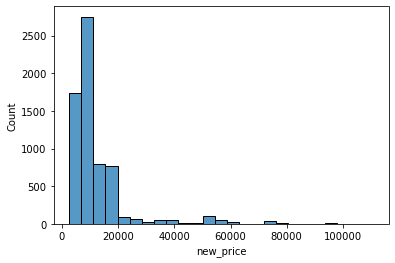

In [90]:
import seaborn as sns
sns.histplot(data=df_final, x='new_price',bins=25)
plt.show()

We see that there are some really high prices. This is not necessarily unexpected since the maximum price of a used car is 55k dollars. 

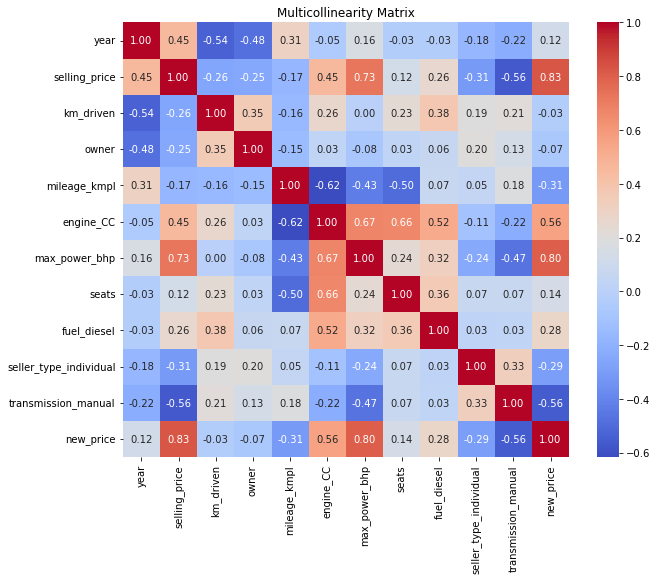

In [91]:
corr = df_final.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Multicollinearity Matrix')
plt.show()

Not surprisingly, mean and median of new_price are higher than the ones of selling_price. There seems to be essentially no correlation between new_price and year or owner. However, new_price is highly correlated with selling_price (the target), and max_power_bhp (one of the most important predictors in part 1 of the project). This means that new_price can potentially be an excellent predictor of selling_price, but the information contained in this column has a lot of overlap with the information contained in max_power_bhp. Thus, the quality of our prediction might improve but they are might not be radically different. 

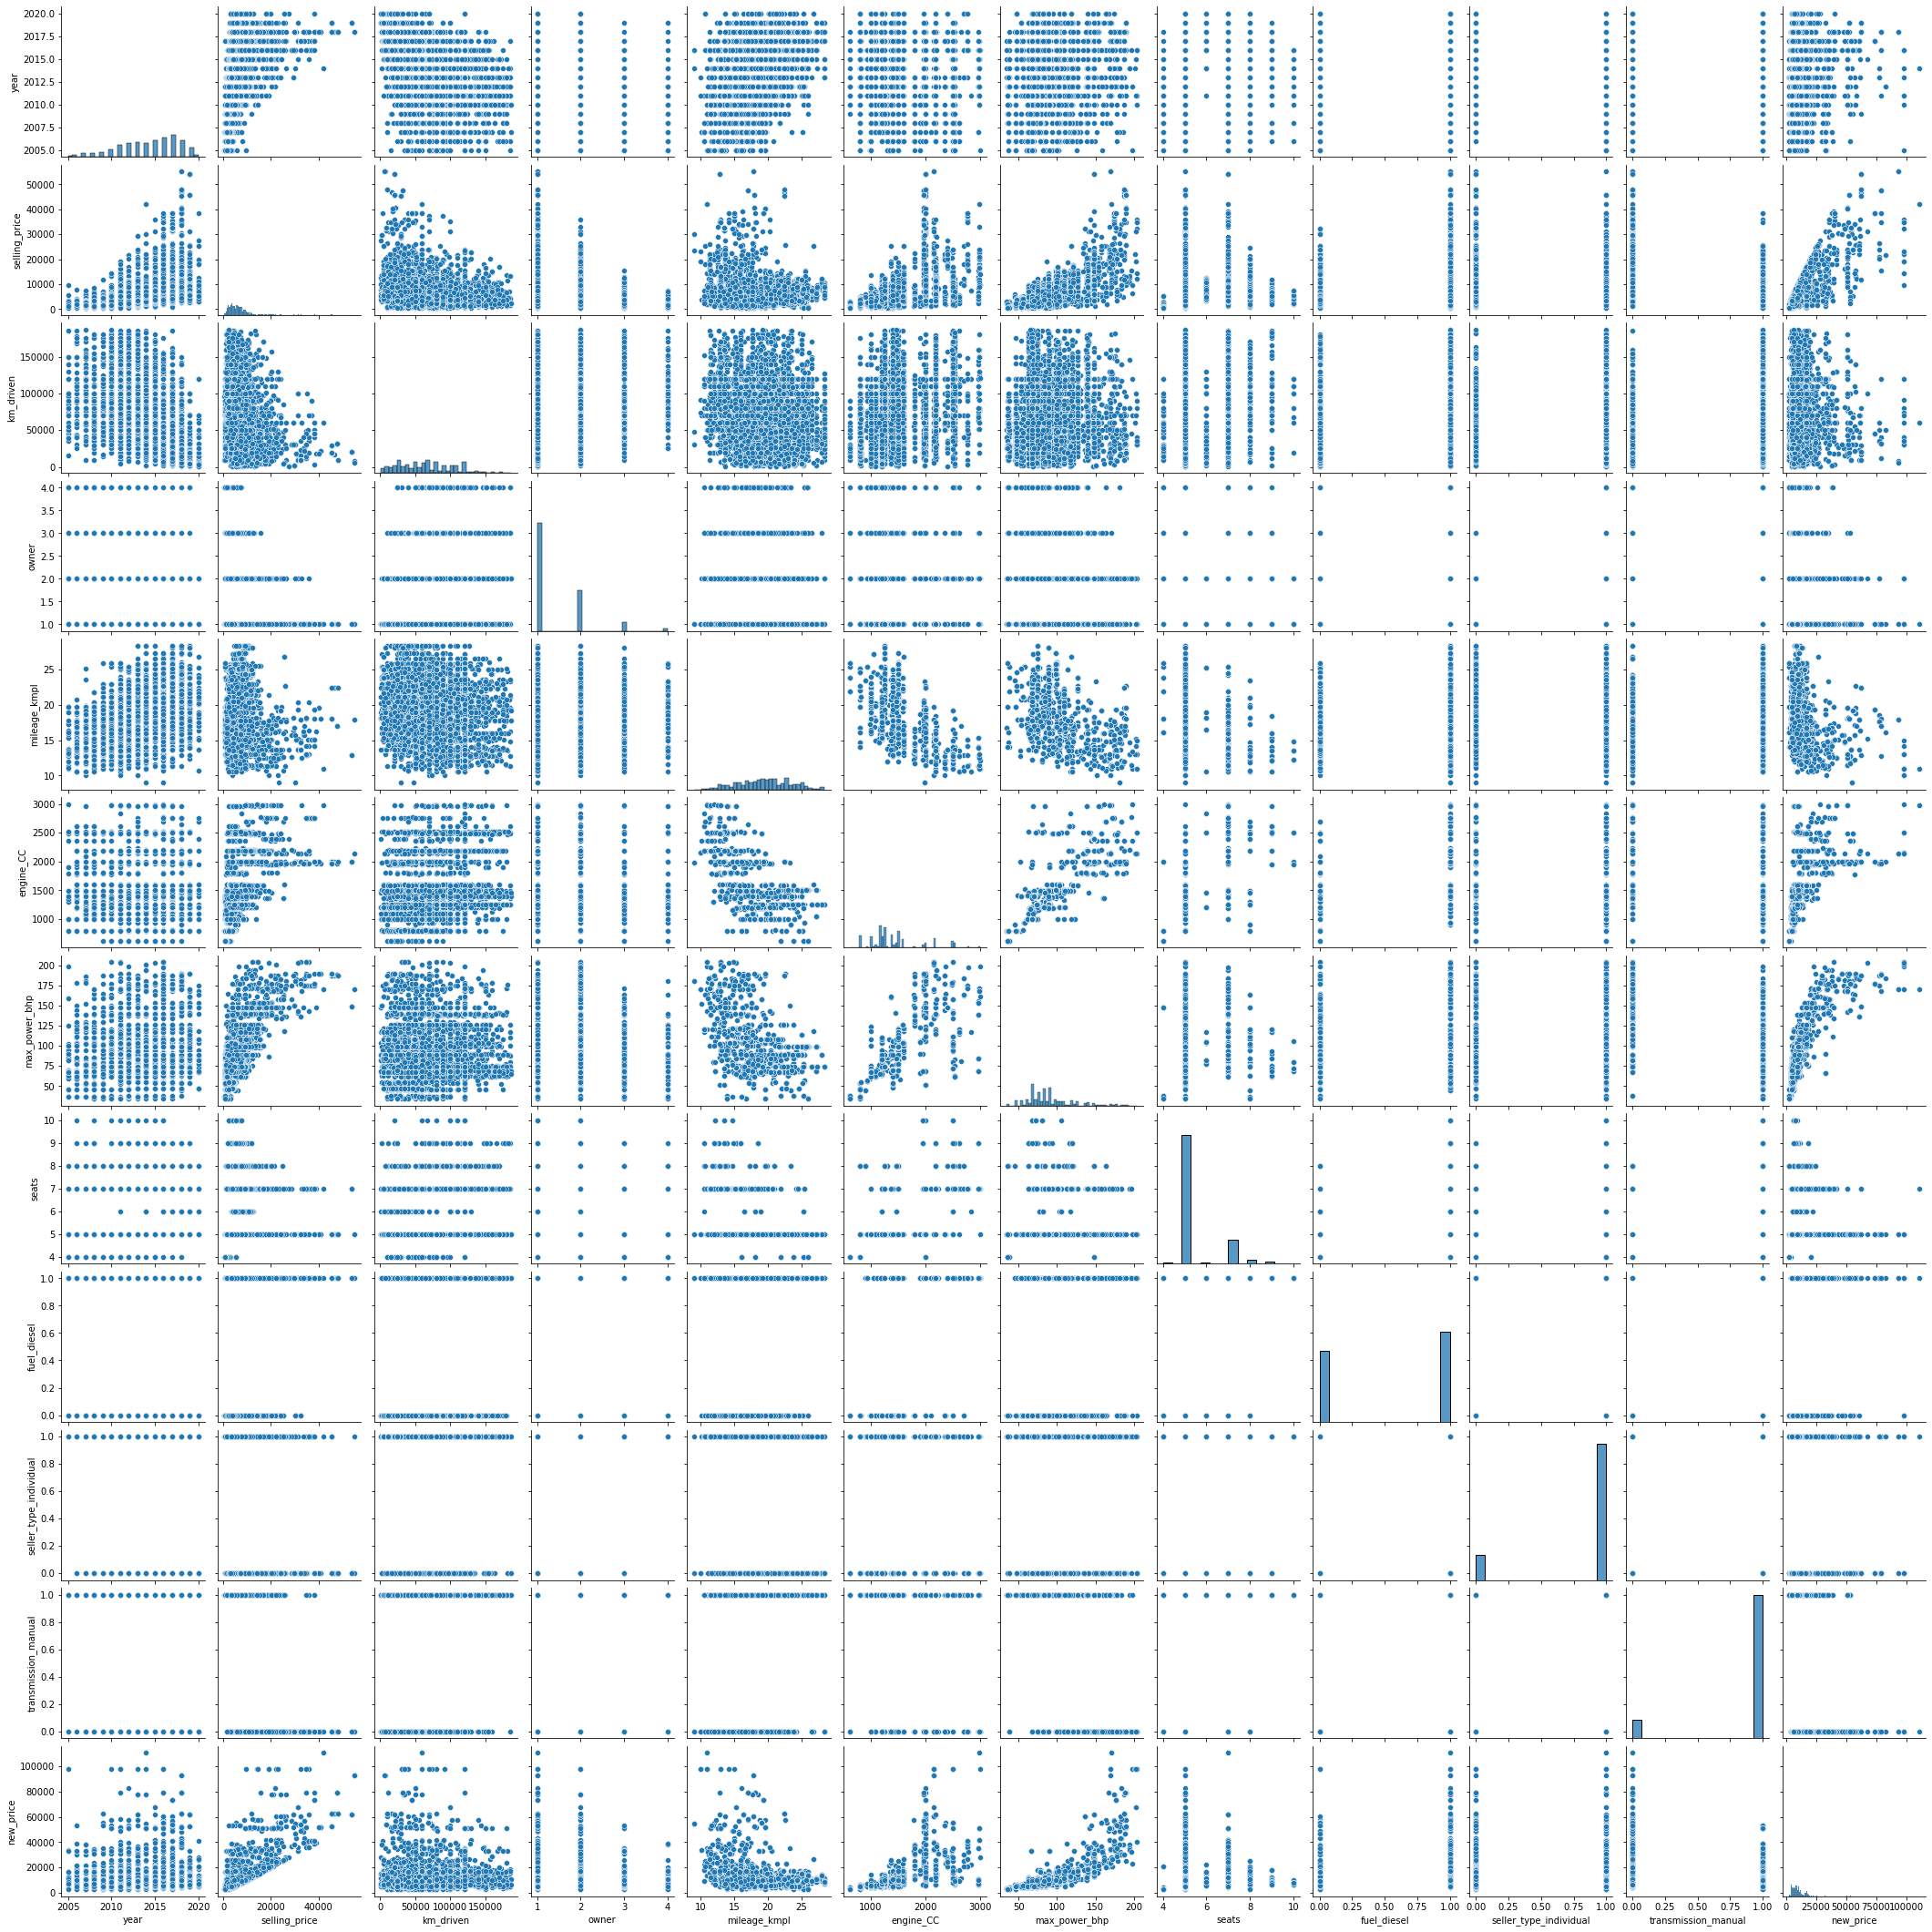

In [38]:
sns.pairplot(df_final)

plt.show()

The plot of selling_price vs new_price indicates the same issue we had before: for high values of new_price (which also correspond to high values of max_power_bhp), the values of selling_price are very noisy. We also notice that new_price vs max_power_bhp seems very similar to selling_price vs max_power_bhp, but the latter contains much more noise. 

Before making new models, let's use the data sets from the old model to split the data exactly like before, so that we can compare the new models to the old models more directly. 

In [5]:
X = df_final.drop('selling_price',axis=1)
y = df_final.selling_price

X_train_new = X.loc[X.index.isin(X_train_2.index)]
X_test_new = X.loc[X.index.isin(X_test_2.index)]
y_train_new = y.loc[y.index.isin(y_train.index)]
y_test_new = y.loc[y.index.isin(y_test.index)]
X_train_smaller_100_new = X.loc[X.index.isin(X_train_smaller_100.index)]
X_test_smaller_100_new = X.loc[X.index.isin(X_test_smaller_100.index)]
y_train_smaller_100_new = y.loc[y.index.isin(y_train_smaller_100.index)]
y_test_smaller_100_new = y.loc[y.index.isin(y_test_smaller_100.index)]
X_train_larger_100_new = X.loc[X.index.isin(X_train_larger_100.index)]
X_test_larger_100_new = X.loc[X.index.isin(X_test_larger_100.index)]
y_train_larger_100_new = y.loc[y.index.isin(y_train_larger_100.index)]
y_test_larger_100_new = y.loc[y.index.isin(y_test_larger_100.index)]

## Linear Model

Like before, let's perform forward and backward selection on the whole data set.

In [6]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
from math import sqrt

def forward_selection(model, X_train, X_test, y_train, y_test):
    n_features = X_train.shape[1]
    feature_names_forward = {}  
    rmse_values_forward_train = []  
    rmse_values_forward_test = []  

    for i in range(1, n_features): 
        model_to_fit = model
        sfs = SequentialFeatureSelector(model_to_fit, n_features_to_select=i, direction='forward')  
        sfs.fit(X_train, y_train)

        X_train_selected = sfs.transform(X_train)
        X_test_selected = sfs.transform(X_test) 

        model_to_fit.fit(X_train_selected, y_train) 

        rmse_train = sqrt(mean_squared_error(y_train, model_to_fit.predict(X_train_selected)))  
        rmse_test = sqrt(mean_squared_error(y_test, model_to_fit.predict(X_test_selected)))  
    
        rmse_values_forward_train.append(rmse_train)
        rmse_values_forward_test.append(rmse_test)

        mask = sfs.get_support()  
        feature_names_forward[i] = X_train.columns[mask]  

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_features), rmse_values_forward_train, marker='o', linestyle='-', markersize=5, label='Train RMSE')  
    plt.plot(range(1, n_features), rmse_values_forward_test, marker='o', linestyle='-', markersize=5, label='Test RMSE')  
    plt.title('RMSE vs Number of Features (Forward Selection)')  
    plt.xlabel('Number of Features')
    plt.ylabel('RMSE')
    plt.legend(fontsize='large')
    plt.show()
    
    previous_features = set()
    count = 0
    for key in sorted(feature_names_forward.keys()):
        current_features = set(feature_names_forward[key])
        new_features = current_features - previous_features
        print(f"{key}: {', '.join(new_features)}")
        previous_features = current_features
        count += 1
        if count == 30:
            break

    return

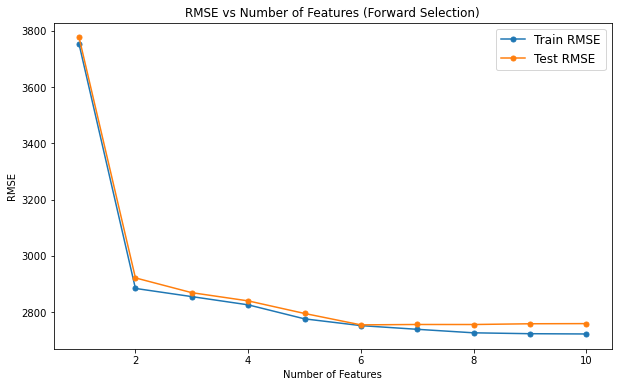

1: new_price
2: year
3: max_power_bhp
4: km_driven
5: fuel_diesel
6: transmission_manual
7: mileage_kmpl
8: engine_CC
9: owner
10: seats


In [155]:
from sklearn.linear_model import LinearRegression

forward_selection(LinearRegression(), X_train_new, X_test_new, y_train_new, y_test_new)

In [7]:
def backward_selection(model, X_train, X_test, y_train, y_test):
    n_features = X_train.shape[1]
    feature_names_backward = {}  
    rmse_values_backward_train = []  
    rmse_values_backward_test = []  

    for i in range(n_features - 1, 0, -1): 
        model_to_fit = model
        sfs = SequentialFeatureSelector(model_to_fit, n_features_to_select=i, direction='backward')  
        sfs.fit(X_train, y_train)

        X_train_selected = sfs.transform(X_train)
        X_test_selected = sfs.transform(X_test) 

        model_to_fit.fit(X_train_selected, y_train) 

        rmse_train = sqrt(mean_squared_error(y_train, model_to_fit.predict(X_train_selected)))  
        rmse_test = sqrt(mean_squared_error(y_test, model_to_fit.predict(X_test_selected)))  
    
        rmse_values_backward_train.append(rmse_train)
        rmse_values_backward_test.append(rmse_test)

        mask = sfs.get_support()  
        feature_names_backward[i] = X_train.columns[mask]  

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_features), rmse_values_backward_train[::-1], marker='o', linestyle='-', markersize=5, label='Train RMSE')  
    plt.plot(range(1, n_features), rmse_values_backward_test[::-1], marker='o', linestyle='-', markersize=5, label='Test RMSE')  
    plt.title('RMSE vs Number of Features (Backward Selection)')  
    plt.xlabel('Number of Features')
    plt.ylabel('RMSE')
    plt.legend(fontsize='large')
    plt.show()
    
    previous_features = set()
    count = 0
    for key in sorted(feature_names_backward.keys()):
        if count >= 30:
            break
        current_features = set(feature_names_backward[key])
        new_features = current_features - previous_features
        print(f"{key}: {', '.join(new_features)}")
        previous_features = current_features
        count += 1

    return 

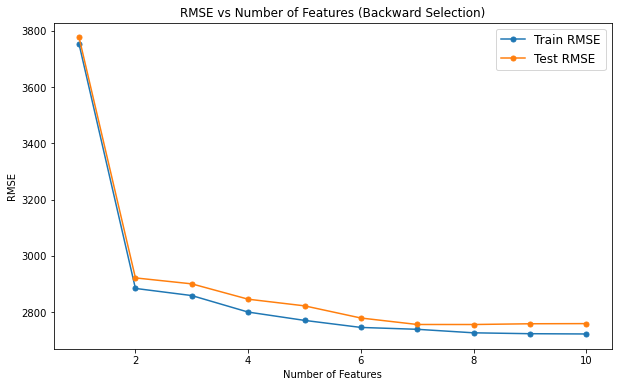

1: new_price
2: year
3: fuel_diesel
4: km_driven
5: mileage_kmpl
6: transmission_manual
7: max_power_bhp
8: engine_CC
9: owner
10: seats


In [161]:
backward_selection(LinearRegression(), X_train_new, X_test_new, y_train_new, y_test_new)

Both selections picked new_price and year as the most important features. However, there are some differences. The most obvious one is that forward selection picked max_power_bhp as the 3rd most important feature, while backward selection dropped it earlier. Both selections agree that seats, owner, and engine_CC are not particularly useful.

In addition, we also notice that the RMSE is much smaller than in the previous part of the project, when the linear model with all features had a test RMSE of 3.46k dollars. We should check whether this is due to the fact that new_price is a very good predictor, or we unintentionally dropped some very noisy data points. To do this, let's train a model without using new_price.

In [8]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_rmse = sqrt(mean_squared_error(y_train, train_preds))
    test_rmse = sqrt(mean_squared_error(y_test, test_preds))
    r2 = r2_score(y_test, test_preds)
    
    print(f"Train RMSE: {train_rmse}")
    print(f"Test RMSE: {test_rmse}")
    print(f"R^2 Score: {r2}")
    
    return model

In [171]:
print('Without new_price')
train_and_evaluate(LinearRegression(), X_train_new.drop('new_price',axis=1), X_test_new.drop('new_price',axis=1), y_train_new, y_test_new);

Without new_price
Train RMSE: 3634.148375452138
Test RMSE: 3506.757782168896
R^2 Score: 0.7285642067651839


In [113]:
print('With new_price')
lr=train_and_evaluate(LinearRegression(), X_train_new, X_test_new, y_train_new, y_test_new);

With new_price
Train RMSE: 2721.6870282721366
Test RMSE: 2759.6447923699648
R^2 Score: 0.8319022316100033


Thus, if we do not use new_price, the test RMSE is essentially the same as in part 1 of the project, meaning that the data we dropped was not responsible for the high RMSE. However, once we do consider new_price, the test RMSE becomes roughly 20% smaller, indicating that new_price is indeed an excellent predictor of selling_price. This also indicates that while new_price is correlated to max_power_bhp, the information these variables contain is not quite the same. 

Let's now select the most interesting features.

In [228]:
from pyplotlm import PyPlotLm

selected_features = ['new_price','year','km_driven','max_power_bhp','fuel_diesel','transmission_manual']
lr_6_features=train_and_evaluate(LinearRegression(), X_train_new[selected_features], X_test_new[selected_features], y_train_new, y_test_new);
print()
print('Intercept:', lr_6_features.intercept_)
for coef, feat in zip(lr_6_features.coef_, selected_features):
    print(f'{feat}: {coef}')
print()
PyPlotLm(lr_6_features,X_train_new[selected_features].values, y_train_new.values,intercept=False).summary()


Train RMSE: 2752.3088335294824
Test RMSE: 2754.9682031728894
R^2 Score: 0.8324714774153228

Intercept: -1172298.727717312
new_price: 0.3864053075613911
year: 583.1949231076492
km_driven: -0.01894170617883599
max_power_bhp: 18.83735358603331
fuel_diesel: 1399.800404255774
transmission_manual: -1456.4844898461315

Residuals:
        Min         1Q   Median        3Q        Max
-28051.8557 -1184.8560 -87.1861 1029.2600 21027.3422

Coefficients:
                  Estimate  Std. Error   t value Pr(>|t|)     
(Intercept)  -1172298.7277  28352.0167  -41.3480   0.0000  ***
X0                  0.3864      0.0061   63.4590   0.0000  ***
X1                583.1949     14.0570   41.4879   0.0000  ***
X2                 -0.0189      0.0013  -14.8355   0.0000  ***
X3                 18.8374      2.0883    9.0203   0.0000  ***
X4               1399.8004     90.7121   15.4312   0.0000  ***
X5              -1456.4845    151.2916   -9.6270   0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.

After a bit of experimenting, we selected these features, which are the ones that we had selected in part 1 of the project plus new_price. However, we noticed that by far, the most important features are new_price and year.

In part 1, we found that the RMSE increased a lot when max_power_bhp > 100. Let's check whether this still is the case. 

In [9]:
def RMSE_vs_max_power(model, X_train, X_test, y_train, y_test):
    threshold_values = range(35, 210, 5)
    rmse_values_train = []
    rmse_values_test = []

    for threshold in threshold_values:
        indices_small_max_power_bhp_train = X_train[X_train.max_power_bhp > threshold].index
        indices_small_max_power_bhp_test = X_test[X_test.max_power_bhp > threshold].index
        
        y_pred_train = model.predict(X_train.drop(indices_small_max_power_bhp_train))
        y_pred_test = model.predict(X_test.drop(indices_small_max_power_bhp_test))
        
        rmse_train = sqrt(mean_squared_error(y_train.drop(indices_small_max_power_bhp_train), y_pred_train))
        rmse_test = sqrt(mean_squared_error(y_test.drop(indices_small_max_power_bhp_test), y_pred_test))
        
        rmse_values_train.append(rmse_train)
        rmse_values_test.append(rmse_test)

    plt.figure(figsize=(10, 6))
    plt.plot(threshold_values, rmse_values_train, marker='o', linestyle='-', markersize=5, label='Train RMSE')
    plt.plot(threshold_values, rmse_values_test, marker='o', linestyle='-', markersize=5, label='Test RMSE')
    plt.xlabel('Threshold value of max_power_bhp')
    plt.ylabel('RMSE')
    plt.title('Train and Test RMSE vs Threshold value of max_power_bhp')
    plt.legend(fontsize='large')
    plt.grid(True)
    plt.show()
    return

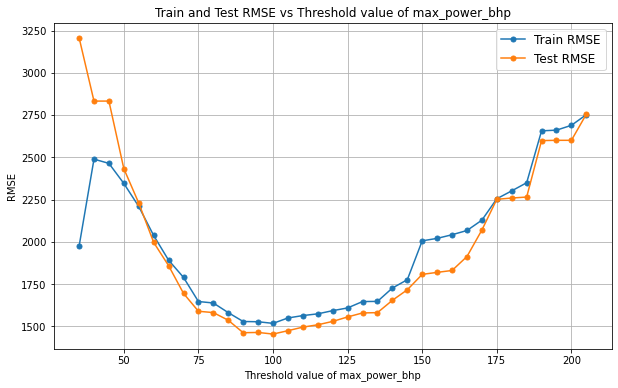

In [232]:
RMSE_vs_max_power(model, X_train_new[['new_price','year','km_driven','max_power_bhp','fuel_diesel','transmission_manual']], X_test_new[['new_price','year','km_driven','max_power_bhp','fuel_diesel','transmission_manual']], y_train_new, y_test_new)

The RMSE is very high at first because only a few data points are considered, and the predictions for these data points happen to be quite off (some of them are actually negative). As more data points are added, the RMSE steadily decreases, until it starts to increase again for high values of max_power_bhp. To make a direct comparison with the models from part 1, let's train two linear models in these regions of the data. 

In [233]:
print('Without new_price and with max_power_bhp < 100')
selected_features = ['year','km_driven','max_power_bhp','fuel_diesel','transmission_manual']
train_and_evaluate(LinearRegression(), X_train_smaller_100_new[selected_features], X_test_smaller_100_new[selected_features], y_train_smaller_100_new, y_test_smaller_100_new);

Without new_price and with max_power_bhp < 100
Train RMSE: 1355.8438859277437
Test RMSE: 1368.587672075341
R^2 Score: 0.7109890661257701


In [234]:
print('With new_price and with max_power_bhp < 100')
selected_features = ['new_price','year','km_driven','max_power_bhp','fuel_diesel','transmission_manual']
train_and_evaluate(LinearRegression(), X_train_smaller_100_new[selected_features], X_test_smaller_100_new[selected_features], y_train_smaller_100_new, y_test_smaller_100_new);

With new_price and with max_power_bhp < 100
Train RMSE: 1249.385133815018
Test RMSE: 1166.4921075523137
R^2 Score: 0.7900418993009518


We see that new_price significantly improves the $R^2$ score (this is true even if we do not include max_power_bhp), but the RMSE is similar to the one of the old model. 

In [238]:
print('Without new_price and with max_power_bhp > 100')
selected_features = ['year','km_driven','max_power_bhp','fuel_diesel','transmission_manual']
train_and_evaluate(LinearRegression(), X_train_larger_100_new[selected_features], X_test_larger_100_new[selected_features], y_train_larger_100_new, y_test_larger_100_new);

Without new_price and with max_power_bhp > 100
Train RMSE: 5285.372704237764
Test RMSE: 4970.026765607039
R^2 Score: 0.7509894322737821


In [239]:
print('With new_price and with max_power_bhp > 100')
selected_features = ['new_price','year','km_driven','max_power_bhp','fuel_diesel','transmission_manual']
train_and_evaluate(LinearRegression(), X_train_larger_100_new[selected_features], X_test_larger_100_new[selected_features], y_train_larger_100_new, y_test_larger_100_new);

With new_price and with max_power_bhp > 100
Train RMSE: 4024.602771067617
Test RMSE: 4014.780900396711
R^2 Score: 0.8375109789902598


For max_power_bhp > 100, both RMSEs are quite high but the model with new_price does perform better. We conclude that neither model is reliable in this region, but including new_price might lead to interesting effects once we consider more flexible models. 

## Polynomial Model

Let's now add polynomial terms up to order two.

In [24]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)

X_train_poly_new = poly.fit_transform(X_train_new)
X_train_poly_new = pd.DataFrame(X_train_poly_new, columns=poly.get_feature_names(X_train_new.columns))


X_test_poly_new = poly.transform(X_test_new)
X_test_poly_new = pd.DataFrame(X_test_poly_new, columns=poly.get_feature_names(X_test_new.columns))

In [25]:
columns_to_omit = ['fuel_diesel^2', 'transmission_manual^2', 'seller_type_individual^2']
X_train_poly_new.drop(columns_to_omit,axis=1,inplace=True)
X_test_poly_new.drop(columns_to_omit,axis=1,inplace=True)

In [243]:
X_train_poly_new.shape[1]

74

We now have 74 features. 

In [26]:
print('Polynomial Model with all Features')
lr_poly=train_and_evaluate(LinearRegression(), X_train_poly_new, X_test_poly_new, y_train_new, y_test_new);

Polynomial Model with all Features
Train RMSE: 1482.8692723202985
Test RMSE: 1495.675140320267
R^2 Score: 0.9506223829019732


Considering that the test RMSE of the old polynomial model from part 1 with all features was 2.1k dollars, this is a great improvement. These results are quite impressive if we keep in mind that the random forest trained in part 1 without new_price had a test RMSE of 1.4k dollars. This means that this relatively simple polynomial model performs almost as well as a random forest! 

Next, let's simplify the model. In fact, of the 74 features we have, only a small subset of them actually gives a significant contribution. 

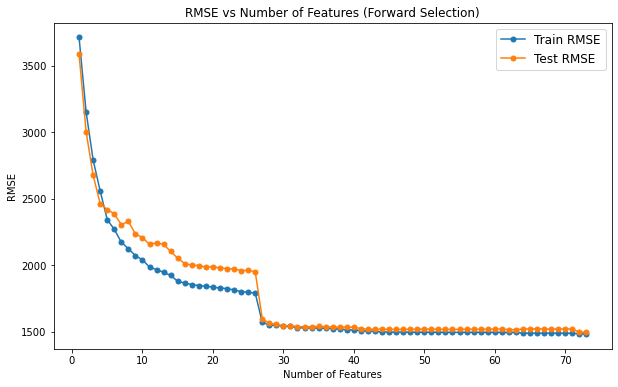

1: mileage_kmpl new_price
2: year^2
3: year mileage_kmpl
4: km_driven new_price
5: fuel_diesel new_price
6: seats new_price
7: km_driven^2
8: owner new_price
9: max_power_bhp^2
10: year
11: mileage_kmpl
12: owner^2
13: seats transmission_manual
14: new_price^2
15: max_power_bhp seats
16: transmission_manual new_price
17: km_driven transmission_manual
18: mileage_kmpl max_power_bhp
19: mileage_kmpl^2
20: km_driven fuel_diesel
21: fuel_diesel seller_type_individual
22: km_driven seller_type_individual
23: max_power_bhp seller_type_individual
24: seats seller_type_individual
25: max_power_bhp new_price
26: new_price
27: year new_price
28: km_driven max_power_bhp
29: owner max_power_bhp
30: year seats


In [249]:
forward_selection(LinearRegression(), X_train_poly_new, X_test_poly_new, y_train_new, y_test_new)

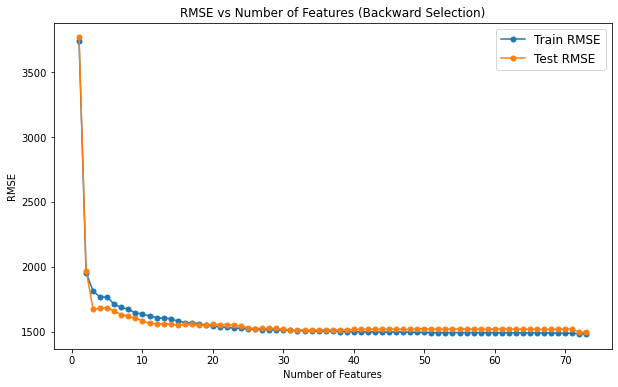

1: year new_price
2: new_price
3: new_price^2
4: fuel_diesel new_price
5: year^2
6: year
7: km_driven max_power_bhp
8: max_power_bhp seller_type_individual
9: year seller_type_individual
10: transmission_manual new_price
11: km_driven transmission_manual
12: engine_CC
13: fuel_diesel
14: mileage_kmpl fuel_diesel
15: mileage_kmpl engine_CC
16: owner max_power_bhp
17: mileage_kmpl
18: mileage_kmpl^2
19: seats new_price
20: year max_power_bhp
21: km_driven owner
22: max_power_bhp seats
23: year fuel_diesel
24: engine_CC transmission_manual
25: max_power_bhp
26: mileage_kmpl max_power_bhp
27: engine_CC^2
28: engine_CC max_power_bhp
29: seller_type_individual
30: year seats


In [ ]:
backward_selection(LinearRegression(), X_train_poly_new, X_test_poly_new, y_train_new, y_test_new)

The results of forward and backward selection are very different. Backward selection seems to have done a better job at identifying the most useful features because as variables are eliminated, the RMSE remains essentially constant and it sharply increases only when the last new_price and new_price^2 are eliminated. 

According to backward selection, the most predictive feature is the interaction term year new_price. However, forward selection added this as the 27th feature. Nevertheless, inspecting the plot of the RMSE vs the number of features for forward selection, we notice that the sharp drop in the RMSE occurs when year new_price is selected. Thus, we can conclude that this interaction is indeed very predictive. 

Let's make a simplified model using what we've learned. First, let's see what happens if we only use year and new_price (including polynomial terms and interaction).

In [296]:
selected_features = ['year new_price','new_price','new_price^2','year^2','year']
train_and_evaluate(LinearRegression(), X_train_poly_new[selected_features], X_test_poly_new[selected_features], y_train_new, y_test_new);

Train RMSE: 1770.8746321439203
Test RMSE: 1650.2721624733447
R^2 Score: 0.9398872322162876


This model performs almost as well as the model containing all 74 features. Let's check what happens if we substitute max_power_bhp to new_price.

In [266]:
selected_features = ['year max_power_bhp','max_power_bhp','max_power_bhp^2','year^2','year']
train_and_evaluate(LinearRegression(), X_train_poly_new[selected_features], X_test_poly_new[selected_features], y_train_new, y_test_new);

Train RMSE: 2859.937573227825
Test RMSE: 2899.4590331069603
R^2 Score: 0.8144377922942996


Performance has significantly decreased. Specifically, the test RMSE almost doubled, while the $R^2$ score decreased by almost 14%. This is evidence that, although max_power_bhp and new_price are correlated, new_price contains much more useful information. 

Let's try to eliminate year and year^2.

In [367]:
selected_features = ['year new_price','new_price','new_price^2']
lr_poly_3=train_and_evaluate(LinearRegression(), X_train_poly_new[selected_features], X_test_poly_new[selected_features], y_train_new, y_test_new);

Train RMSE: 1811.5315750069096
Test RMSE: 1672.6037498307267
R^2 Score: 0.9382493250053638


We see that performance has slightly decreased but the results are essentially the same as before. 

After experimenting a bit, we are certain that the 3 most important features are year new_price, new_price, and new_price^2. However, it is not clear what the next best features are since none of them greatly improves the model. To deal with this issue, let's try to perform a forward selection in which year new_price, new_price, and new_price^2 are preselected, and the 10 next best features are selected. Then, we will perform backward selection on these features.

In [12]:
from sklearn.model_selection import cross_val_score

def partial_forward_selection(model, X_train, X_test, y_train, y_test, preselected_features):
    n_features = X_train.shape[1]
    feature_names_forward = {}  
    rmse_values_forward_train = []  
    rmse_values_forward_test = []  

    X_train_preselected = X_train[preselected_features]
    X_test_preselected = X_test[preselected_features]

    model.fit(X_train_preselected, y_train)
    rmse_train_preselected = sqrt(mean_squared_error(y_train, model.predict(X_train_preselected)))  
    rmse_test_preselected = sqrt(mean_squared_error(y_test, model.predict(X_test_preselected)))  

    remaining_features = list(set(X_train.columns) - set(preselected_features))

    for i in range(10): 
        best_rmse = float('inf')
        best_feature = None

        for feature in remaining_features:
            X_train_try = pd.concat([X_train_preselected, X_train[feature]], axis=1)
            scores = cross_val_score(model, X_train_try, y_train, cv=5, scoring='neg_root_mean_squared_error')
            rmse = -scores.mean()  

            if rmse < best_rmse:
                best_rmse = rmse
                best_feature = feature

        preselected_features.append(best_feature)
        remaining_features.remove(best_feature)

        model.fit(X_train[preselected_features], y_train)
        rmse_train = sqrt(mean_squared_error(y_train, model.predict(X_train[preselected_features])))  
        rmse_test = sqrt(mean_squared_error(y_test, model.predict(X_test[preselected_features])))  

        rmse_values_forward_train.append(rmse_train)
        rmse_values_forward_test.append(rmse_test)

        feature_names_forward[i] = list(preselected_features)  

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), rmse_values_forward_train, marker='o', linestyle='-', markersize=5, label='Train RMSE')  
    plt.plot(range(1, 11), rmse_values_forward_test, marker='o', linestyle='-', markersize=5, label='Test RMSE')  
    plt.axhline(y=rmse_train_preselected, color='r', linestyle='--', label='Train RMSE (preselected features)')
    plt.axhline(y=rmse_test_preselected, color='g', linestyle='--', label='Test RMSE (preselected features)')
    plt.title('RMSE vs Number of Features (Forward Selection)')  
    plt.xlabel('Number of Features')
    plt.ylabel('RMSE')
    plt.legend(fontsize='large')
    plt.show()

    for key in sorted(feature_names_forward.keys()):
        if key == 0:
            print(f"Feature selected at step {key+1}: {feature_names_forward[key][-1]}")
        else:
            new_feature = set(feature_names_forward[key]) - set(feature_names_forward[key-1])
            print(f"Feature selected at step {key+1}: {', '.join(new_feature)}")

    return feature_names_forward[9]

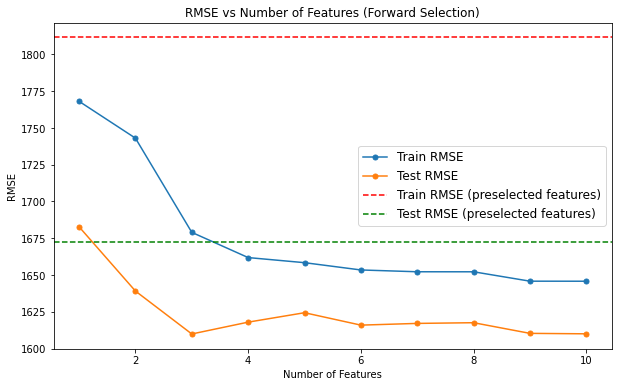

Feature selected at step 1: fuel_diesel new_price
Feature selected at step 2: seller_type_individual new_price
Feature selected at step 3: km_driven new_price
Feature selected at step 4: mileage_kmpl new_price
Feature selected at step 5: max_power_bhp seats
Feature selected at step 6: km_driven max_power_bhp
Feature selected at step 7: max_power_bhp fuel_diesel
Feature selected at step 8: seats new_price
Feature selected at step 9: km_driven mileage_kmpl
Feature selected at step 10: engine_CC fuel_diesel


In [337]:
preselected_features =  ['year new_price','new_price','new_price^2']
candidate_features = partial_forward_selection(LinearRegression(), X_train_poly_new, X_test_poly_new, y_train_new, y_test_new, preselected_features)

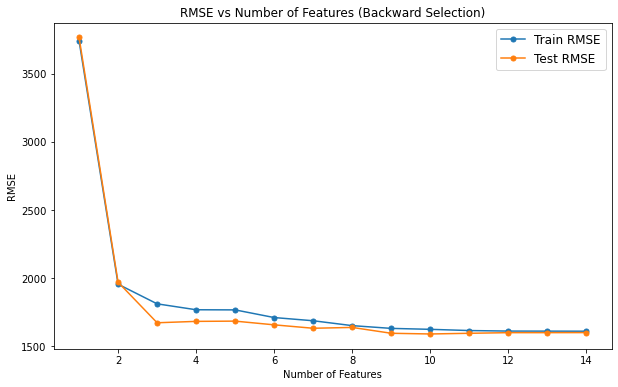

1: year new_price
2: new_price
3: new_price^2
4: fuel_diesel new_price
5: year^2
6: year
7: km_driven max_power_bhp
8: max_power_bhp seats
9: seller_type_individual new_price
10: km_driven mileage_kmpl
11: mileage_kmpl new_price
12: km_driven new_price
13: engine_CC fuel_diesel
14: max_power_bhp fuel_diesel


In [338]:
candidate_features.extend(['year','year^2'])
backward_selection(LinearRegression(), X_train_poly_new[candidate_features], X_test_poly_new[candidate_features], y_train_new, y_test_new)

We added year and year^2 to the backward selection since they weren't selected by the partial forward selection. These results are similar to before. It is clear that fuel_diesel new_price is also somewhat useful since it was selected as the first new feature in the partial forward selection, and it was dropped just before new_price^2 in the backward selection. km_driven max_power_bhp might also be useful.

In [345]:
selected_features = ['year new_price','new_price','new_price^2','year^2','year','fuel_diesel new_price']
train_and_evaluate(LinearRegression(), X_train_poly_new[selected_features], X_test_poly_new[selected_features], y_train_new, y_test_new);

Train RMSE: 1710.8771243498086
Test RMSE: 1657.3821967900435
R^2 Score: 0.9393681365602689


In [347]:
selected_features = ['year new_price','new_price','new_price^2','year^2','year','fuel_diesel new_price','km_driven max_power_bhp']
train_and_evaluate(LinearRegression(), X_train_poly_new[selected_features], X_test_poly_new[selected_features], y_train_new, y_test_new);

Train RMSE: 1687.3692969734625
Test RMSE: 1632.272835214501
R^2 Score: 0.9411913671800183


In [350]:
selected_features = ['year new_price','new_price','new_price^2','year^2','year','fuel_diesel new_price','km_driven max_power_bhp',
                    'max_power_bhp seller_type_individual','year seller_type_individual','transmission_manual new_price',
                    'km_driven transmission_manual','engine_CC']
train_and_evaluate(LinearRegression(), X_train_poly_new[selected_features], X_test_poly_new[selected_features], y_train_new, y_test_new);

Train RMSE: 1609.0580763145224
Test RMSE: 1560.9106019284125
R^2 Score: 0.946221134303322


All these improvements are very small. We conclude that only 3 features (year new_price , new_price , new_price^2) are needed to obtain good estimates. For better estimates, one might use all the 74 polynomial features. For intermediate results, one might add year^2 , year, fuel_diesel new_price, km_driven max_power_bhp to the model with 3 features. For even better performance, one might add a custom number of features in the order selected by the backward selection on the whole polynomial data set.

Now that we identified the most important features, let's check how the models perform for max_power_bhp < 100 and max_power_bhp >= 100. We will train the models in these regions of the data set, but performance is very similar to the models trained on the whole data set.  

In [354]:
print('All polynomial features with max_power_bhp < 100')
train_and_evaluate(LinearRegression(), X_train_poly_new[X_train_poly_new.max_power_bhp < 100], X_test_poly_new[X_test_poly_new.max_power_bhp < 100], y_train_smaller_100_new, y_test_smaller_100_new);

All polynomial features with max_power_bhp < 100
Train RMSE: 892.4245156761814
Test RMSE: 900.2756481723254
R^2 Score: 0.8749395370878053


In [356]:
print('3 selected polynomial features with max_power_bhp < 100')
selected_features = ['year new_price','new_price','new_price^2']
train_and_evaluate(LinearRegression(), X_train_poly_new.loc[X_train_poly_new.max_power_bhp < 100,selected_features], X_test_poly_new.loc[X_test_poly_new.max_power_bhp < 100,selected_features], y_train_smaller_100_new, y_test_smaller_100_new);

3 selected polynomial features with max_power_bhp < 100
Train RMSE: 1011.4676823235959
Test RMSE: 976.7365901406633
R^2 Score: 0.8527945325131493


In [359]:
print('All polynomial features with max_power_bhp >= 100')
train_and_evaluate(LinearRegression(), X_train_poly_new[X_train_poly_new.max_power_bhp >= 100], X_test_poly_new[X_test_poly_new.max_power_bhp >= 100], y_train_larger_100_new, y_test_larger_100_new);

All polynomial features with max_power_bhp > 100
Train RMSE: 2145.613323007728
Test RMSE: 2370.1055499595373
R^2 Score: 0.94337141657854


In [362]:
print('3 selected polynomial features with max_power_bhp >= 100')
selected_features = ['year new_price','new_price','new_price^2']
train_and_evaluate(LinearRegression(), X_train_poly_new.loc[X_train_poly_new.max_power_bhp >= 100,selected_features], X_test_poly_new.loc[X_test_poly_new.max_power_bhp >= 100,selected_features], y_train_larger_100_new, y_test_larger_100_new);

3 selected polynomial features with max_power_bhp >= 100
Train RMSE: 3028.7183179887165
Test RMSE: 2733.9388103268325
R^2 Score: 0.9246509287439356


In [365]:
print('12 selected polynomial features with max_power_bhp >= 100')
selected_features = ['year new_price','new_price','new_price^2','year^2','year','fuel_diesel new_price','km_driven max_power_bhp',
                    'max_power_bhp seller_type_individual','year seller_type_individual','transmission_manual new_price',
                    'km_driven transmission_manual','engine_CC']
train_and_evaluate(LinearRegression(), X_train_poly_new.loc[X_train_poly_new.max_power_bhp >= 100,selected_features], X_test_poly_new.loc[X_test_poly_new.max_power_bhp >= 100,selected_features], y_train_larger_100_new, y_test_larger_100_new);

12 selected polynomial features with max_power_bhp >= 100
Train RMSE: 2460.680177757729
Test RMSE: 2410.2975920106987
R^2 Score: 0.9414345267497545


For max_power_bhp < 100, the performance of the two models are quite similar. Obviously, the more complex model performs better, but the model with only 3 features is almost as accurate. 

For max_power_bhp >= 100, the more complex model performs significantly better, and this difference becomes smaller and smaller as we add more features picked by backward selection. 

In part 1 of the project, the random forest test RMSE was 0.8k dollars for max_power_bhp < 100, and 2.3k dollars for max_power_bhp >= 100. The polynomial with all features has comparable performance in both regions of the data set. 

For completeness, let's check how the models trained on the whole training data perform in the two different regions of the data set. 

In [10]:
def evaluate(model, X_train, X_test, y_train, y_test):
    
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_rmse = sqrt(mean_squared_error(y_train, train_preds))
    test_rmse = sqrt(mean_squared_error(y_test, test_preds))
    r2 = r2_score(y_test, test_preds)
    
    print(f"Train RMSE: {train_rmse}")
    print(f"Test RMSE: {test_rmse}")
    print(f"R^2 Score: {r2}")
    
    return 

In [369]:
print('All polynomial features with max_power_bhp < 100')
evaluate(lr_poly, X_train_poly_new[X_train_poly_new.max_power_bhp < 100], X_test_poly_new[X_test_poly_new.max_power_bhp < 100], y_train_smaller_100_new, y_test_smaller_100_new);

All polynomial features with max_power_bhp < 100
Train RMSE: 975.6066050413705
Test RMSE: 957.9704752813009
R^2 Score: 0.8583967325727793


In [370]:
print('3 selected polynomial features with max_power_bhp < 100')
selected_features = ['year new_price','new_price','new_price^2']
evaluate(lr_poly_3, X_train_poly_new.loc[X_train_poly_new.max_power_bhp < 100,selected_features], X_test_poly_new.loc[X_test_poly_new.max_power_bhp < 100,selected_features], y_train_smaller_100_new, y_test_smaller_100_new);

3 selected polynomial features with max_power_bhp < 100
Train RMSE: 1015.3525184063224
Test RMSE: 979.6840101749312
R^2 Score: 0.851904771680159


In [371]:
print('All polynomial features with max_power_bhp >= 100')
evaluate(lr_poly, X_train_poly_new[X_train_poly_new.max_power_bhp >= 100], X_test_poly_new[X_test_poly_new.max_power_bhp >= 100], y_train_larger_100_new, y_test_larger_100_new);

All polynomial features with max_power_bhp >= 100
Train RMSE: 2345.171107233402
Test RMSE: 2340.5660066636215
R^2 Score: 0.9447741880490357


In [372]:
print('3 selected polynomial features with max_power_bhp >= 100')
selected_features = ['year new_price','new_price','new_price^2']
evaluate(lr_poly_3, X_train_poly_new.loc[X_train_poly_new.max_power_bhp >= 100,selected_features], X_test_poly_new.loc[X_test_poly_new.max_power_bhp >= 100,selected_features], y_train_larger_100_new, y_test_larger_100_new);

3 selected polynomial features with max_power_bhp >= 100
Train RMSE: 3039.5776616157673
Test RMSE: 2704.1762006635267
R^2 Score: 0.9262825513737973


Thus, as previously mentioned, performance is essentially the same. 

## Tree-Based Models

To conclude this project, let's assess the performance of tree-based models.

In [21]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor

def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

param_grid = {
    'n_estimators': range(50, 600, 75),
    'max_features':['sqrt', 'log2', None, 5.0],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10, 25, 40]
}

rf_trial = RandomForestRegressor(n_jobs=4)

grid_search = GridSearchCV(estimator=rf_trial, param_grid=param_grid,
                           cv=KFold(n_splits=5), n_jobs=-1, scoring=rmse_scorer)

grid_search.fit(X_train_new, y_train_new)

best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")

C:\Users\Francesco\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [-1196.20192554 -1189.97436965 -1191.05982676 ...            nan
            nan            nan]
  warnings.warn(


Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [88]:
train_and_evaluate(RandomForestRegressor(n_estimators=200,max_depth=20,max_features='sqrt',min_samples_leaf=1,min_samples_split=2), X_train_new, X_test_new, y_train_new, y_test_new)

Train RMSE: 434.1768456498584
Test RMSE: 1185.7785330141364
R^2 Score: 0.9689642142953286


RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=200)

In [22]:
from xgboost import XGBRegressor
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'eta': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
}


xgb = XGBRegressor(objective='reg:squarederror')


grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring=rmse_scorer)


grid_search.fit(X_train_new, y_train_new)


best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")

Best parameters: {'eta': 0.3, 'max_depth': 5}


In [23]:
xgb_best = XGBRegressor(**best_params)
xgb_best.fit(X_train_2, y_train)

y_pred_train_best = xgb_best.predict(X_train_2)
y_pred_test_best = xgb_best.predict(X_test_2)

print('Train RMSE tuned xgb: %.2f' % sqrt(mean_squared_error(y_train, y_pred_train_best)))
print('Test RMSE tuned xgb: %.2f' % sqrt(mean_squared_error(y_test, y_pred_test_best)))

Train RMSE tuned xgb: 753.66
Test RMSE tuned xgb: 1377.38


Once again, we see that the random forest performs slightly better. However, like in part 1 of the project, we see that there is a dramatic difference between the train RMSE and the test RMSE. Thus, although the model has been tuned, it is possible that overfitting is still occurring. Let's try to tune the random forest with different values of the parameters. 

In [74]:
param_grid = {
    'max_features':range(1,10),
    'max_depth': range(1,15,2),
    'min_samples_split': range(1,10,2),
    'min_samples_leaf': range(1,15,3)
}

rf_trial = RandomForestRegressor(n_estimators=200,n_jobs=4)

grid_search = GridSearchCV(estimator=rf_trial, param_grid=param_grid,
                           cv=KFold(n_splits=5), n_jobs=-1, scoring=rmse_scorer)

grid_search.fit(X_train_new, y_train_new)

best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")

C:\Users\Francesco\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [           nan -5377.33219145 -5399.21554767 ... -1426.68182308
 -1425.90034423 -1433.21878458]
  warnings.warn(


Best parameters: {'max_depth': 13, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 3}


In [11]:
rf=train_and_evaluate(RandomForestRegressor(n_estimators=200,max_depth=13,max_features=7,min_samples_leaf=1,min_samples_split=3), X_train_new, X_test_new, y_train_new, y_test_new)

Train RMSE: 565.6841882336806
Test RMSE: 1178.4823664352384
R^2 Score: 0.9693449693852517


This is essentially the same as before. We also noticed that we can change the parameters to make the train and test RMSEs more similar to each other but, although this would prevent overfitting, the overall test RMSE would increase, meaning that performance would not improve. Thus, we conclude that the best model is the second random forest we trained. 

Let's now evaluate this model for max_power_bhp < 100 and max_power_bhp > 100.

In [12]:
print('RF with max_power_bhp < 100')
evaluate(rf, X_train_new[X_train_new.max_power_bhp < 100], X_test_new[X_test_new.max_power_bhp < 100], y_train_smaller_100_new, y_test_smaller_100_new);

RF with max_power_bhp < 100
Train RMSE: 427.8305837861586
Test RMSE: 728.8687451104666
R^2 Score: 0.9180275942674557


In [13]:
print('RF with max_power_bhp >= 100')
evaluate(rf, X_train_new[X_train_new.max_power_bhp >= 100], X_test_new[X_test_new.max_power_bhp >= 100], y_train_larger_100_new, y_test_larger_100_new);

RF with max_power_bhp >= 100
Train RMSE: 826.1455523410624
Test RMSE: 1869.6548841093984
R^2 Score: 0.9647610288565367


This model performs better than the random forest we obtained in part 1 of the project. To confirm that this is due to the fact that we added the variable new_price, let's train a random forest with the same hyper parameters without new_price.

In [97]:
rf_without_new_price=train_and_evaluate(RandomForestRegressor(n_estimators=200,max_depth=13,max_features=7,min_samples_leaf=1,min_samples_split=3), X_train_new.drop('new_price',axis=1), X_test_new.drop('new_price',axis=1), y_train_new, y_test_new)

Train RMSE: 695.9636507331116
Test RMSE: 1440.2791341934483
R^2 Score: 0.9542122909037636


In [99]:
print('RF without new_price and with max_power_bhp < 100')
evaluate(rf_without_new_price, X_train_new.drop('new_price',axis=1)[X_train_new.max_power_bhp < 100], X_test_new.drop('new_price',axis=1)[X_test_new.max_power_bhp < 100], y_train_smaller_100_new, y_test_smaller_100_new);

RF without new_price and with max_power_bhp < 100
Train RMSE: 531.2905481804873
Test RMSE: 822.8222890487303
R^2 Score: 0.8955325193886038


In [100]:
print('RF with max_power_bhp >= 100')
evaluate(rf_without_new_price, X_train_new.drop('new_price',axis=1)[X_train_new.max_power_bhp >= 100], X_test_new.drop('new_price',axis=1)[X_test_new.max_power_bhp >= 100], y_train_larger_100_new, y_test_larger_100_new);

RF with max_power_bhp >= 100
Train RMSE: 1009.5999030742271
Test RMSE: 2346.765163612863
R^2 Score: 0.9444812615954977


These RMSE values are very similar to what we obtained in part 1 but that the $R^2$ has significantly decreased. Thus, performance is very similar to before and the model is not fitting the training data as well, which hopefully means that we mitigated the overfitting issue we were initially having. Regardless of this, we are pleased to notice that performance in the region where max_power_bhp > 100 has significantly improved thanks to new_price.

The last thing we want to assess is the relationship between the data points with high residuals and new_price. To do this, we will use the predictions of the polynomial model with all features since we need a reasonably high number of outlier residuals.

In [36]:
predictions = lr_poly.predict(X_test_poly_new)
residuals = y_test_new - predictions
residuals = pd.Series(residuals)

Q1 = residuals.quantile(0.25)
Q3 = residuals.quantile(0.75)
IQR = Q3 - Q1

outlier_indices = list(np.where((residuals < (Q1 - 1.5 * IQR)) | (residuals > (Q3 + 1.5 * IQR)))[0])

df_test_residuals = X_test_poly_new.copy()
df_test_residuals['selling_price'] = y_test_new
df_test_residuals['high_residual'] = 0
df_test_residuals.iloc[outlier_indices, df_test_residuals.columns.get_loc('high_residual')] = 1

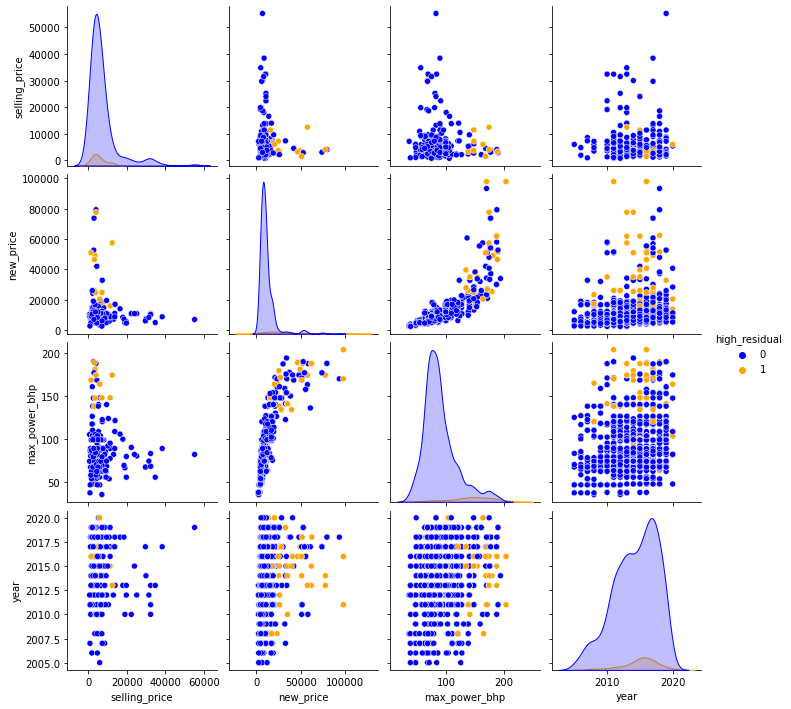

In [37]:
import seaborn as sns

palette = {0: 'blue', 1: 'orange'}
sns.pairplot(df_test_residuals[['selling_price','new_price','max_power_bhp','year','high_residual']], hue='high_residual', palette=palette)
plt.show()

The above plots, especially new_price vs max_power_bhp, confirm that the model struggles to make accurate predictions for data points with a high value of max_power_bhp and a high value of new_price. This is not too surprising because we know that these variables are highly correlated. 

## Summary

In order to improve accuracy, we added a new feature called new_price to our data set. This variable contains a rough estimate of the price of the car models when they were new. In order to obtain this information, we scraped two websites: cardekho (website from which the used car listings were also scraped from) and carwale. We managed to find a reasonable estimate of new_price for a bit over 90% of the data points from the cleaned data set used in part 1, so that final data set we used had 6.6k data points. By inspecting the correlation matrix, we noticed that new_price has a correlation of 0.83 with the target selling_price.

After this, we trained a few linear models. The model trained with all features had a test RMSE of 2.76k dollars and $R^2$ of 0.83. These are respectively a 21% and 14% improvement with respect to the models trained without new_price. The model trained where max_power_bhp < 100 had a test RMSE of 1.17k dollars, which a 14% improvement with respect to the model without new_price. Both models performed poorly when trained where max_power_bhp > 100. Forward and backward selection on the whole data set gave us slightly different results, but they agreed that new_price and year are the most important features. The simplified model trained with the 5 features selected in part 1 plus new_price had test RMSE = 2.75k dollars and $R^2$=0.83. This is essentially the same results obtained using all features, meaning that a few variables are not useful. In addition, we confirmed that if new_price is dropped, the model looks very similar to the one obtained in part 1, meaning that the data points we dropped where not responsible for the high RMSEs. 

Next, we trained a polynomial model with terms up to order two (interactions included). Using all 74 features, we obtained a test RMSE of 1.5k dollars and a $R^2$ score of 0.95. These are respectively a 29% and 6% improvement from the polynomial model from part 1 trained with all 62 features that did not include new_price. Additionally, the test RMSE of our new polynomial model was only 7.1% worse than the one of the random forest obtained in part 1. This is very impressive considering that in part 1, the polynomial model with 62 features had a test RMSE almost 52% higher than the random forest. When trained for max_power_bhp < 100, the new polynomial model had a test RMSE of 0.9k dollars (10.5% higher than the random forest from part 1) and an $R^2$ of 0.875, while when trained for max_power_bhp $\geq$ 100, the test RMSE was 2.37k dollars (2.46% higher than the random forest from part 1) and the $R^2$ was 0.94. 

Once again, we simplified the model using forward and backward selection. This time, the selected features were very different. The most important feature according to backward selection was the interaction term year new_price. This variable was selected as the 27th feature by forward selection, which seems to indicate that it might not be so useful. However, inspecting the plot of the RMSE vs the number of selected feature, one can observe that once forward selection adds this feature, the RMSE sharply decreases, confirming that this feature is indeed very important. The next very important features are new_price and new_price^2. Using only these 3 features, the test RMSE is 1.67k dollars and the $R^2$ is 0.938. However, we noticed that while the model trained for max_power_bhp < 100 had a test RMSE of 0.98k dollars, the model trained for  max_power_bhp $\geq$ 100 the test RMSE of 2.7k dollars. This means that for max_power_bhp < 100, the polynomial model with 3 features is almost as good as the polynomial model with 74 features, and it is reasonably better than the linear model. However, for max_power_bhp $\geq$ 100, the polynomial model with 74 features in considerably better since its test RMSE is 15% lower. In addition, using the results of backward selection, one can build a more complex model with an arbitrary number of features. For example, one might add fuel_diesel new_price, year^2, year, and so on.

After this, we trained flexible tree-based models. As in part 1, the best performing model was a random forest. After tuning, we obtained a test RMSE of 1.18k dollars and an $R^2$ of 0.97. Although the $R^2$ has slightly decreased, the test RMSE is 15.6% smaller than in part 1, meaning that the predictions made using new_price are more accurate. As in part 1, we might have an overfitting problem. However, after tuning we concluded that in order to make the train RMSE more similar to the test RMSE, we also have to increase the test RMSE. Thus, while the predictions on the training data are considerably better, the predictions on the testing data are still the best we can hope to obtain using a random forest. In addition, for max_power_bhp < 100 the test RMSE is 0.73k dollars, while for max_power_bhp $\geq$ 100 the test RMSE is 1.87k dollars. These are respectively a 10.5% and a 19.2% improvement with respect to the random forest from part 1. Thus, using new_price significantly improved performance, especially in the region where max_power_bhp $\geq$ 100.

Finally, we used the predictions of the polynomial model with 74 variables to check the features of the data points for which the residuals are very high. We observed that the model struggles to make predictions for cars that had a high new_price. This is not surprising since we know that new_price and max_power_bhp are highly correlated (0.8 correlation). Thus, if max_power_bhp $\geq$ 100, then new_price is large. 

## Conclusion and Future Work

Our original goal was to assess whether any important information was missing from the original data set. We scraped the original price of the cars models in the data set that we used in part 1, and we found that this variable significantly improves performance of all models that we obtained in part 1. This improvement is especially evident in the region where max_power_bhp $\geq$ 100, in which the test RMSE improved by 24.1% for the polynomial model with all features, and by 19.2% for the random forest. Because of this, we conclude that new_price is indeed a very useful predictor, especially in the more noisy region of the data.

We think that new_price is such a useful feature not only because it happens to be highly correlated with the target selling_price, but also because this variable is a good summary of several features that are (and some that are not) contained in the data set. In fact, given the features selected, the two main predictors of the value of a used car are its original price and its current condition. While features like year and km_driven give us information about the current condition of a car, new_price gives a good rough estimate of the value of the car when it was new, making features like max_power_bhp almost useless. 

Although we did manage to significantly improve the accuracy of the predictions, the predictions for max_power_bhp $\geq$ 100 could still improve. In order to do this, it would be useful to know the year of the car models (rather than just the year in which the previous owner bought the car). This would not only allow us to have access to a potentially really good predictor, but it would also help us to improve our estimate of the original price of the cars. In addition, given our results we conclude that although we were right suspecting that some important information was missing from the original data set, it is also difficult to make accurate prediction for cars with an original high price (which happen to be powerful cars). This is not just because some important feature might still be missing, but also because this region of the data is much noisier. 